## Installing Required Packages

In [ ]:
# !pip install earthpy
# !pip install plotly
# !pip install openpyxl
# !pip install rasterio
# !pip install fiona
# !pip install geopandas
# !pip install spyndex
# !pip install rioxarray
# !pip install xarray
# !pip install shap
# !pip install tqdm
# !pip install imbalanced-learn
# !pip install --upgrade xgboost
# !pip install ipympl
# !pip install feature-engine

  Using cached earthpy-0.9.4-py3-none-any.whl (1.4 MB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.7.5
    Uninstalling python-dateutil-2.7.5:
      Successfully uninstalled python-dateutil-2.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cmip6-preprocessing 0.6.0 requires pint-xarray, which is not installed.
sat-stac 0.4.1 requires python-dateutil~=2.7.5, but you have python-dateutil 2.8.2 which is incompatible.
intake-esm 2021.8.17 requires h5netcdf>=0.8.1, but you have h5netcdf 0.0.0 which is incompatible.
cmip6-preprocessing 0.6.0 requires xgcm<0.7.0, but you have xgcm 0.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 38.8 MB/s eta 0:00:0000:0100:01
  Using cached openpyxl-3.1.1-py2.py3-none-any.whl (24

## Importing Packages

In [ ]:
from notebook.services.config import ConfigManager
import warnings
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": True}}})
warnings.filterwarnings("ignore")

In [ ]:
{
    "codeCellConfig": {
        "codeFolding": True
    }
}

In [4]:
from glob import glob
import os, sys
import re
from os import listdir
import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio
import fiona
import rasterio.mask
from rasterio.plot import show
from rasterio import plot as rp
import pandas as pd
import math
import geopandas as gpd
import seaborn as sns
from IPython.display import Image
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numpy as np
import matplotlib
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.metrics import jaccard_score, log_loss, balanced_accuracy_score, make_scorer, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, GridSearchCV, cross_validate
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn import utils
from imblearn.over_sampling import SMOTE
import pickle
from xgboost import XGBClassifier
import scipy.ndimage
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
%matplotlib inline

## Import Image and Ground Reference

Image bands 8
Probability bands 1
Image crs:  EPSG:32636
Probability crs:  EPSG:32636
Cols 173
Rows 177


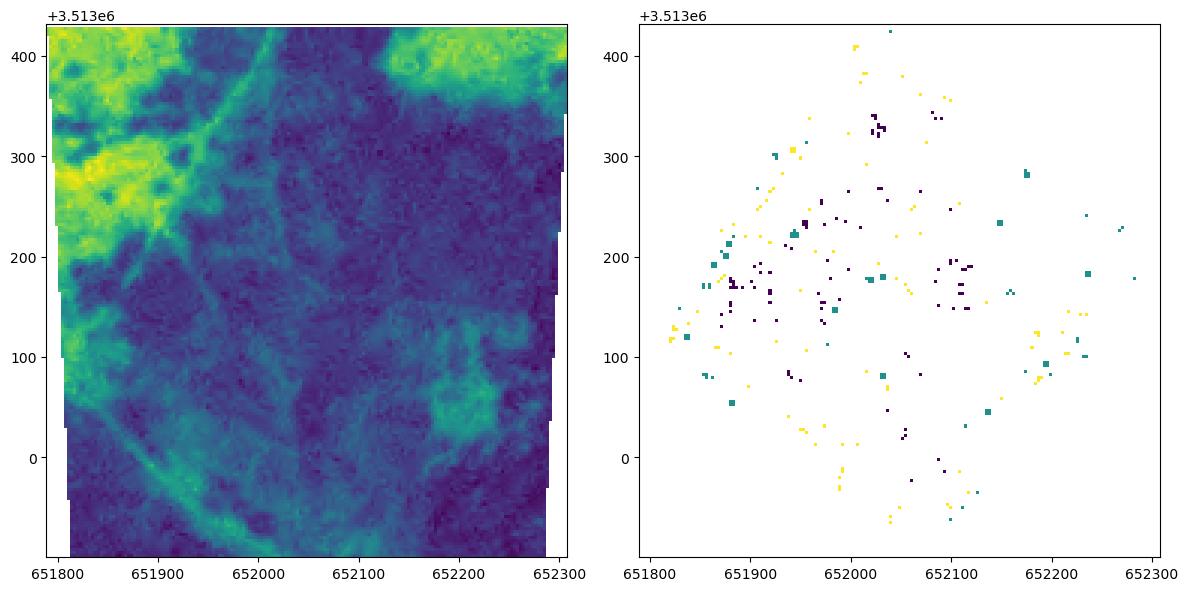

In [5]:
img = rio.open("./Input_Images/PlanetMosaic_04Nov2022_Warp_FromDrone3m.tif")
pbl = rio.open("./Input_Images/PlanetMosaic_04Nov2022_Class_FromDrone3m.tif")
# pbl = rio.open("./Input_Images/PlanetMosaic_04Nov2022_Class_FromDrone3m.tif")
tiff_extent = [img.bounds[0], img.bounds[2], img.bounds[1], img.bounds[3]]
print('Image bands', img.count)
print('Probability bands', pbl.count)
print('Image crs: ', img.crs)
print('Probability crs: ', pbl.crs)
print('Cols', img.width)
print('Rows', img.height)
noBands = img.count

def apply_mask_class(pb):
    pb = np.where(pb == -1, np.nan, pb)
    return pb

pbl_r = pbl.read(1)
pbl_r = apply_mask_class(pbl_r)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), tight_layout=True)
show(img, ax=ax1, extent=tiff_extent , transform=img.transform)
show(pbl_r, ax=ax2, extent=tiff_extent , transform=img.transform)
plt.show()

In [6]:
image = []
for i in range(1,noBands+1):
    image.append(apply_mask_class(img.read(i)/10000))

image.append(pbl_r)
image_r = np.stack(image, axis=0)
image_r.shape

(9, 177, 173)

In [7]:
image_df = pd.DataFrame(image_r.reshape([noBands+1,-1]).T, \
                        columns=['B1','Blue','G1','Green','Yellow','Red','RedEdge','NIR','Class'])
image_df = image_df[['Blue','Green','Red', 'NIR','Class']]
print('Data Matrix (Original) ', image_df.shape)
# image_df = image_df[(image_df.T != -1).all()]
# image_df = image_df[(image_df.T != 3).any()]
image_df.dropna(axis=0, how='any', inplace=True)
print('Data Matrix (Cleaned) ', image_df.shape)
image_df['Class'] = image_df["Class"].astype('uint8').astype('category')
image_df.dtypes

Data Matrix (Original)  (30621, 5)
Data Matrix (Cleaned)  (299, 5)


Blue      float64
Green     float64
Red       float64
NIR       float64
Class    category
dtype: object

In [8]:
image_df["Class"].value_counts()

1    100
2    100
0     99
Name: Class, dtype: int64

In [9]:
sampledData = utils.shuffle(image_df.groupby("Class").head(99), random_state=8)
sampledData["Class"].value_counts()

0    99
1    99
2    99
Name: Class, dtype: int64

## Common functions for data preparation and generating results

In [10]:
# matplotlib.rc_file_defaults()
%matplotlib inline

# Function for classification outcomes
def classificationDetails(model, trainData, trainLabels, testData, testLabels, predLabels, predProb, modelName):
    
    # Accuracy of the model
    accuracy = accuracy_score(testLabels, predLabels)
    print('Classification Accuracy of the model: {:.2f}%'.format(accuracy*100))
    
    jaccard = jaccard_score(testLabels, predLabels, average=None)
    jaccard = np.round(jaccard, 4)
    print('Jaccard Score of the model: ', jaccard)
    
    ovr_auc = roc_auc_score(testLabels, predProb, labels = model.classes_, multi_class = 'ovr', average = None)
    ovr_auc = np.round(ovr_auc, 4)
    print('ROC AUC (OvR) Score of the model: ', ovr_auc)
    
    # Confusion matrix
    print("Confusion Matrix")
    target_names = ["Heterotheca", "Outgroup", "Soil"]
    cm = confusion_matrix(testLabels, predLabels, labels = model.classes_, normalize='true')
    cm = cm * 100
    # cm = confusion_matrix(testLabels, predLabels, labels = model.classes_)
    # print(matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    # model.classes_
    plt.figure(figsize=(3,3))
    plt.rcParams.update({'font.size': 14})
    disp.plot(cmap=plt.cm.Blues,values_format='.2f')
    plt.tight_layout()
    plt.savefig('./Outputs/Stats/ConfusionMatrix_'+modelName+'.png', dpi = 300, bbox_inches = 'tight')
    
    # Classification Report
    print("\nClassification Report")
    report = classification_report(testLabels, predLabels, target_names=target_names, digits=3)
    print(report)
    report = classification_report(testLabels, predLabels, target_names=target_names, digits=3, output_dict=True)
    report.update({"accuracy": {"precision": None, "recall": None, "f1-score": report["accuracy"], "support": report['macro avg']['support']}})
    report.update({"jaccard": {"precision": jaccard[0], "recall": jaccard[1], "f1-score": jaccard[2], "support": None}})
    report.update({"OvR_AUC": {"precision": ovr_auc[0], "recall": ovr_auc[1], "f1-score": ovr_auc[2], "support": None}})
    reportDF = pd.DataFrame(report).transpose()
    # reportDF.to_csv('./Outputs/Stats/classReport_'+modelName+'.csv')
    return

In [18]:
def applyFullImage(imageName, datasetType, model, modelName):
    # Image loading and size checking
    img_val = rio.open(imageName+'.tif')
    head, tail = os.path.split(imageName+'.tif')
    fname, fext = os.path.splitext(tail)
    tiff_extent = [img_val.bounds[0], img_val.bounds[2], img_val.bounds[1], img_val.bounds[3]]
    print('Image bands', img_val.count)
    print('Image crs: ', img_val.crs)
    rows = img_val.height
    cols = img_val.width
    # print('Cols', cols)
    # print('Rows', rows)
    noBandsVal = img_val.count
    im1 = img_val.read(1)
    # Converting image to dataframe
    img_r = []
    for i in range(1, noBandsVal+1):
        temp = img_val.read(i)
        img_r.append(temp/10000)

    img_r = np.stack(img_r, axis=0)
    img_df = pd.DataFrame(img_r.reshape([noBands,-1]).T, \
                          columns=['B1','Blue','G1','Green','Yellow','Red','RedEdge','NIR'])
    img_df = img_df[['Blue','Green','Red','NIR']]

    img_df = img_df.replace(-1, np.nan)
    img_df = img_df.replace(0, np.nan)
    
    if datasetType == '4Bands':
        img_df = img_df
    else:
        img_df = computeIndices(img_df)
    
    img_df = img_df.replace(np.nan, -1)
    
    # Predict probability (3 bands generated)
    # band 0 - Heterotheca
    # band 1 - Outgroup
    # band 2 - Soil
    y_pred_prob = model.predict_proba(img_df)
    
    def apply_mask_border(img, gt):
        img = np.where(gt == 0, np.nan, img)
        return img
        
    y_pred_prob_reshape = np.zeros((3, rows, cols))
    y_pred_prob_reshape[0, :, :] = y_pred_prob[:,0].reshape(rows, cols)
    y_pred_prob_reshape[1, :, :] = y_pred_prob[:,1].reshape(rows, cols)
    y_pred_prob_reshape[2, :, :] = y_pred_prob[:,2].reshape(rows, cols)
    
    for i in range(0, 3):
        y_pred_prob_reshape[i, :, :] = apply_mask_border(y_pred_prob_reshape[i, :, :], im1)
    
    # Predict classes
    y_pred_val = model.predict(img_df) # Default classification threshold is 0.5
    y_pred_val = y_pred_val.astype('float32')
    # im1 = im1.reshape([1, -1]).T
    # y_pred_val = y_pred_val.reshape([1, -1]).T
    
    # background_mask = im1 == -1
    # y_pred_val[background_mask] = -1
    
    # y_pred_val = model.predict_proba(img_df)
    # y_pred_val = (y_pred_val[:,0] >= 0.65).astype(int)
    # y_pred_val = model.predict(img_df) # Default classification threshold is 0.5
        
    y_pred_val_reshape = np.reshape(y_pred_val, (1, rows, cols))
    y_pred_val_reshape = apply_mask_border(y_pred_val_reshape, im1)
    
    # Removing isolated pixels from the classified image
    # tmp = scipy.ndimage.convolve(y_pred_val_reshape, np.ones((3,3)), mode='constant')
    # y_pred_val_reshape = np.logical_and(tmp >= 4, y_pred_val_reshape).astype(np.float32)
    
    # y_pred_val_reshape = np.reshape(y_pred_val_reshape, (1, rows, cols))
    # y_pred_prob_reshape = np.reshape(y_pred_prob[:,0], (1, rows, cols)) 
    
    # def apply_mask_image(img, gt):
    #     img = np.where(gt == -1, np.nan, img)
    #     return img
    
    meta = img_val.meta.copy()
    meta.update({'count':1})
    meta.update({'dtype':'float32'})
    meta.update({'nodata':-1})
    metaprob = img_val.meta.copy()
    metaprob.update({'count':3})
    metaprob.update({'dtype':'float32'})
    metaprob.update({'nodata':-1})
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9), tight_layout=True)
    show(img_val, ax=ax1, extent=tiff_extent , transform=img_val.transform)
    show(y_pred_val_reshape, ax=ax2, extent=tiff_extent , transform=img_val.transform)
    show(y_pred_prob_reshape, ax=ax3, extent=tiff_extent , transform=img_val.transform)
    plt.show()
    
    outfilename = './Outputs/Images/' + fname + '_' + datasetType + '_' + modelName + '.tif'
    outprobfilename = './Outputs/Images/' + fname + '_' + datasetType + '_' + modelName + '_Prob.tif'
    # with rio.open(outfilename, 'w', **meta) as out:
    #     out.write(y_pred_val_reshape)
    # with rio.open(outprobfilename, 'w', **metaprob) as outprob:
    #     outprob.write(y_pred_prob_reshape)
    return

In [13]:
def plot_feature_importance(importance, names, model_type, modelName):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(8,6))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    # plt.savefig('./Outputs/Stats/FeatureImportance_'+modelName+'.png', dpi = 300, bbox_inches = 'tight')
    return

In [14]:
# Final index - NDYI, SAVI, EBI, BI, NBRRI
def computeIndices(df):
    df1 = df[['Blue', 'Green', 'Red', 'NIR']]
    # df1['SlopeGB'] = df["Green"] - df["Blue"]
    df1['NDYI'] = (df["Green"] - df["Blue"])/(df["Green"] + df["Blue"])
    # df1['NDVI'] = (df["NIR"] - df["Red"]) / (df["NIR"] + df["Red"])
    df1['SAVI'] = (2 * (df["NIR"] - df["Red"])) / (df["NIR"] + df["Red"] + 1)
    # df1['VDVI'] = (2 * df["Green"] - df["Red"] - df["Blue"]) / (2 * df["Green"] + df["Red"] + df["Blue"])
    # df1['MGRVI'] = (np.power(df["Green"], 2) - np.power(df["Red"], 2)) / (np.power(df["Green"], 2) + np.power(df["Red"], 2))
    df1['EBI'] = (df[["Blue", "Green", "Red"]].sum(axis=1)) / ((df["Green"] / df["Blue"]) * (df["Red"] - df["Blue"] + 1))
    # df1['GNDVI'] = (df["NIR"] - df["Green"]) / (df["NIR"] + df["Green"])
    df1['BI'] = np.power(((np.power(df["Red"], 2) + np.power(df["Green"],2) + np.power(df["Blue"],2))/3),0.5)
    df1['NBRRI'] = (df["Red"] - df["Blue"])/(df["Red"] + df["Blue"])
    # Blue-wide dynamic range vegetation index (BWDRVI)
    # df1['SI'] = (df["Red"] - df["Blue"])/(df["Red"] + df["Blue"])
    # Saturation index has same formula as NBRRI, hence we are using NBRRI
    # hsv = matplotlib.colors.rgb_to_hsv(df[['Red','Green','Blue']])
    # hsv = np.round(hsv, 6)
    # hsv = pd.DataFrame(hsv, index=df.index, columns=['Hue', 'Saturation', 'Value'])
    # df1 = pd.concat([df1, hsv[['Hue', 'Saturation']]], axis=1)
    return df1

## Multiclass Accuracy Curves (Common Functions)

In [17]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [15]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [16]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## OvR ROC Curves

In [19]:
def OvR_ROC(model, X_test, y_test, y_proba, datasetType, modelName):
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    plt.figure(figsize = (12, 8))
    bins = [i/20 for i in range(20)] + [1]
    classes = model.classes_
    roc_auc_ovr = {}
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = X_test.copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_proba[:, i]
        df_aux = df_aux.reset_index(drop = True)

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 3, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(c)
        ax.legend([f"Class: {c}", "Rest"])
        ax.set_xlabel(f"P(x = {c})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("ROC Curve OvR")

        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    plt.tight_layout()
    
    # Displays the ROC AUC for each class
    avg_roc_auc = 0
    i = 0
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    
    # plt.savefig('./Outputs/OneVsRest_ROC_Curves_'+datasetType+'_'+modelName+'.png', dpi = 300, bbox_inches = 'tight')
    return None

## Correlation amongst factors

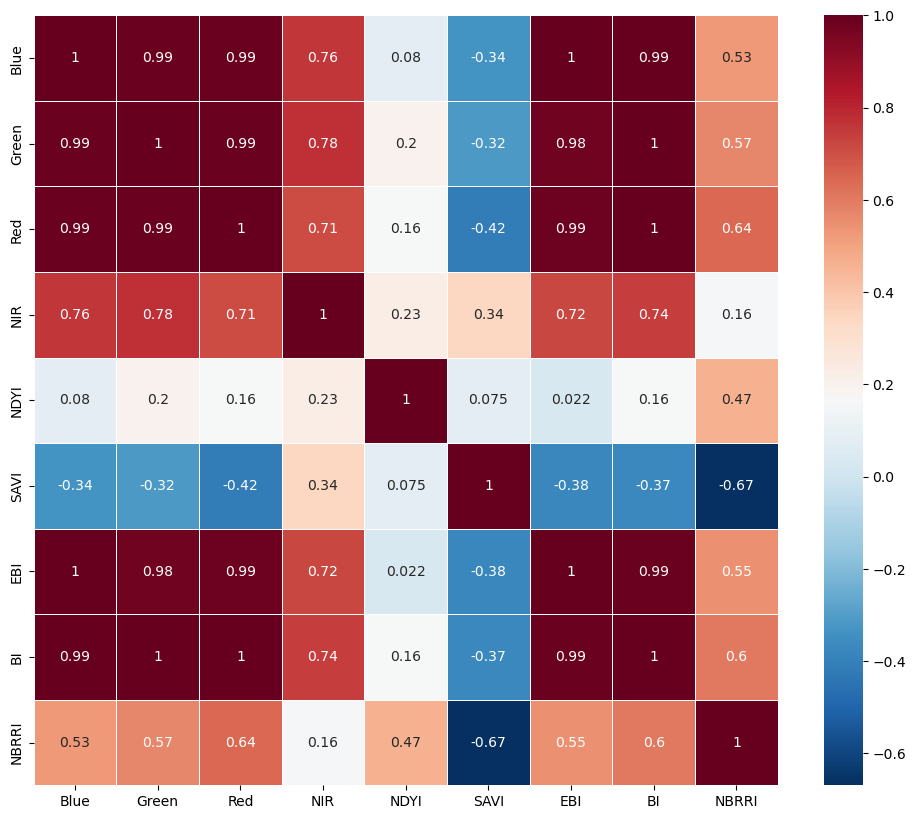

In [16]:
import seaborn as sns

testDF = computeIndices(image_df.loc[:, image_df.columns != "Class"])
pearsoncorr = testDF.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, 
           yticklabels=pearsoncorr.columns, 
           cmap='RdBu_r', annot=True,linewidth=0.5)
plt.savefig('CorrelationPlot_Factors_Planet_newTrained.png', bbox_inches='tight', dpi=300, transparent=False)

## Train - Test Split

In [20]:
X = sampledData.iloc[: , :4]
y = sampledData.iloc[: , 4]

withIndices = input('Do you want indices ? (y/n)')
if withIndices == 'y':
    X = computeIndices(X)
    datasetType = str(X.shape[1]) + 'Bands'
else:
    datasetType = '4Bands'
    X = X

# shape = X.shape  # For last execution random_state = 10
# noNewBands = shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)

# Two-sample Kolmogorov-Smirnov test for checking the train and test distribution
ks2_test = ks_2samp(y_train, y_test)
print(ks2_test)

train_test_data = './Outputs/TrainTestData/' + datasetType + '_train_test_data_newTrained.xlsx'

# with pd.ExcelWriter(train_test_data, engine="openpyxl") as writer:
#     tempTrnDF = pd.concat([X_train, y_train], axis=1)
#     tempTrnDF.to_excel(writer, sheet_name='TrainData', index=True, header=True)
#     tempTstDF = pd.concat([X_test, y_test], axis=1)
#     tempTstDF.to_excel(writer, sheet_name='TestData', index=True, header=True)
# writer=None

Do you want indices ? (y/n) y


KstestResult(statistic=0.0, pvalue=1.0)


In [18]:
# Test Image Name
imageName = 'PlanetMosaic_04Nov2022_Warp_FromDrone3m'

In [20]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

## Basic Random Forest

In [21]:
clf = RandomForestClassifier(n_estimators=60, max_depth=3, n_jobs=-1, random_state = 10)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=3)

# evaluate model
# scores = cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=-1)
# summarize performance
# print('Mean ROC AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=60, n_jobs=-1, random_state=10)

In [22]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)
modelName = input("Input model name for saving results")

Input model name for saving results Model_RF_NoHPT_newTrained


Classification Accuracy of the model: 76.67%
Jaccard Score of the model:  [0.6316 0.6    0.6316]
ROC AUC (OvR) Score of the model:  [0.9211 0.9011 0.9528]
Confusion Matrix

Classification Report
              precision    recall  f1-score   support

 Heterotheca      0.750     0.800     0.774        30
    Outgroup      0.808     0.700     0.750        30
        Soil      0.750     0.800     0.774        30

    accuracy                          0.767        90
   macro avg      0.769     0.767     0.766        90
weighted avg      0.769     0.767     0.766        90



<Figure size 300x300 with 0 Axes>

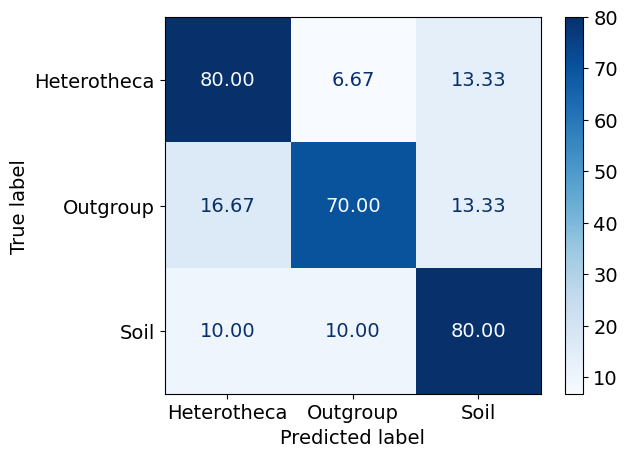

In [23]:
# Classification Results
classificationDetails(clf, X_train, y_train, X_test, y_test, y_pred, y_proba, datasetType + '_' + modelName)

In [24]:
# Pickle Save
dumpName = './Outputs/Models/' + datasetType + '_' + modelName + '.pkl'
pickle.dump(clf, open(dumpName, 'wb'))

# Load trained model
# clf = pickle.load(open(dumpName, 'rb'))
# y_pred = clf.predict(X_test)

Image bands 8
Image crs:  EPSG:32636


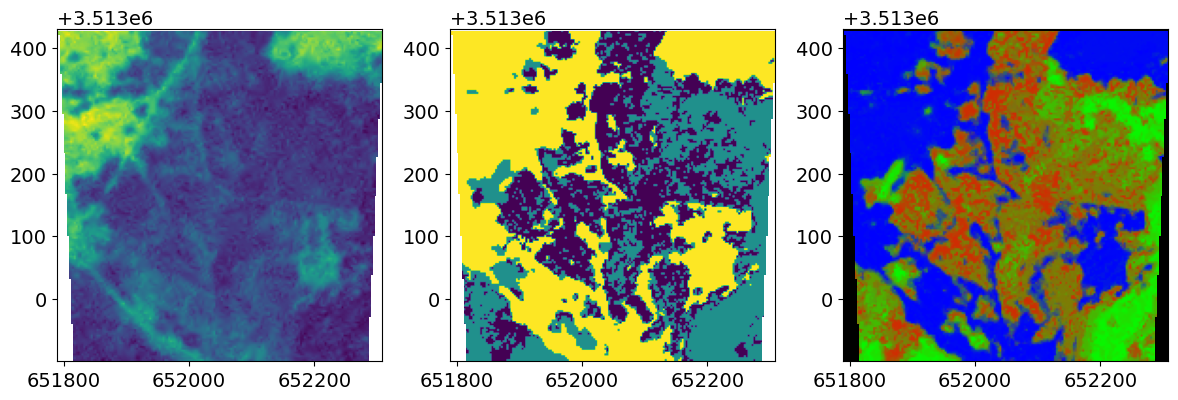

0 ROC AUC OvR: 0.9211
1 ROC AUC OvR: 0.9011
2 ROC AUC OvR: 0.9528
average ROC AUC OvR: 0.9250


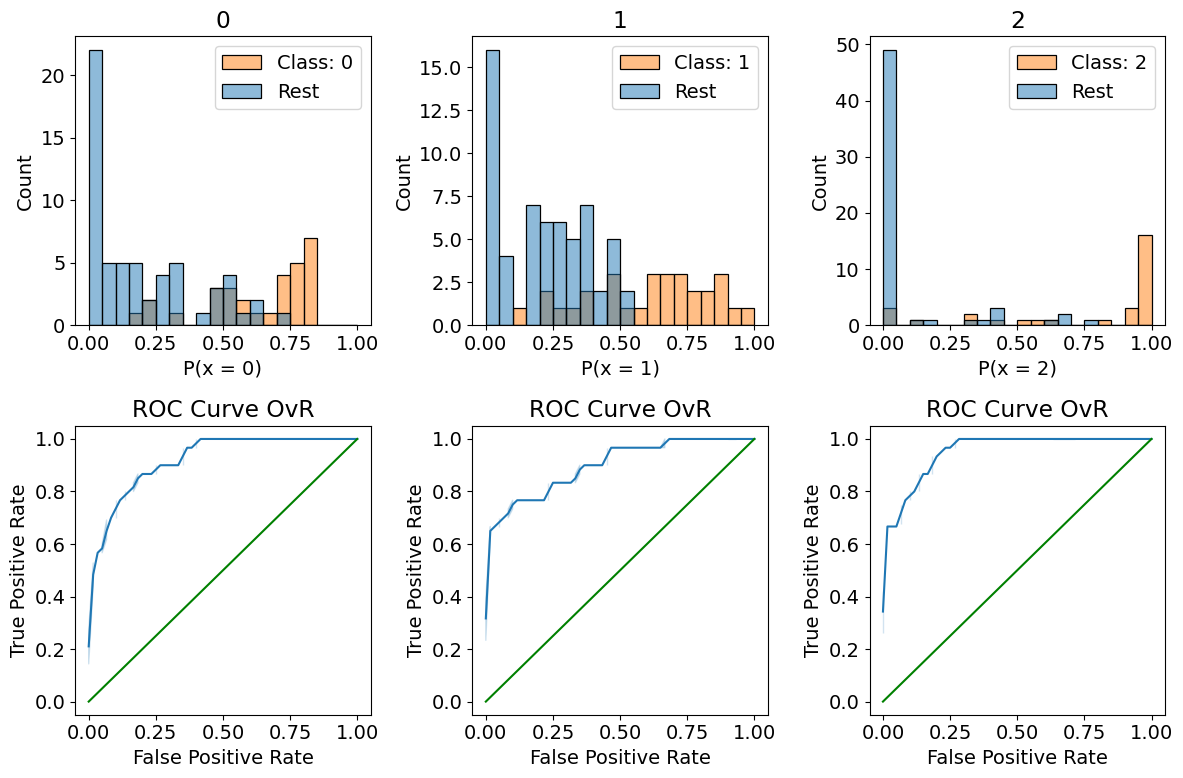

In [25]:
# Apply basic model on full image
# matplotlib.rc_file_defaults()
import seaborn as sns
applyFullImage(imageName, datasetType, clf, modelName)
OvR_ROC(clf, X_test, y_test, y_proba, datasetType, modelName)

## Feature Importance

In [26]:
feature_list = list(X_train.columns)
print('Feature List', feature_list)
importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature List ['Blue', 'Green', 'Red', 'NIR', 'NDYI', 'SAVI', 'EBI', 'BI', 'NBRRI']
Variable: Blue                 Importance: 0.19
Variable: Red                  Importance: 0.18
Variable: EBI                  Importance: 0.15
Variable: BI                   Importance: 0.13
Variable: SAVI                 Importance: 0.12
Variable: Green                Importance: 0.07
Variable: NDYI                 Importance: 0.07
Variable: NBRRI                Importance: 0.06
Variable: NIR                  Importance: 0.04


<Figure size 300x200 with 0 Axes>

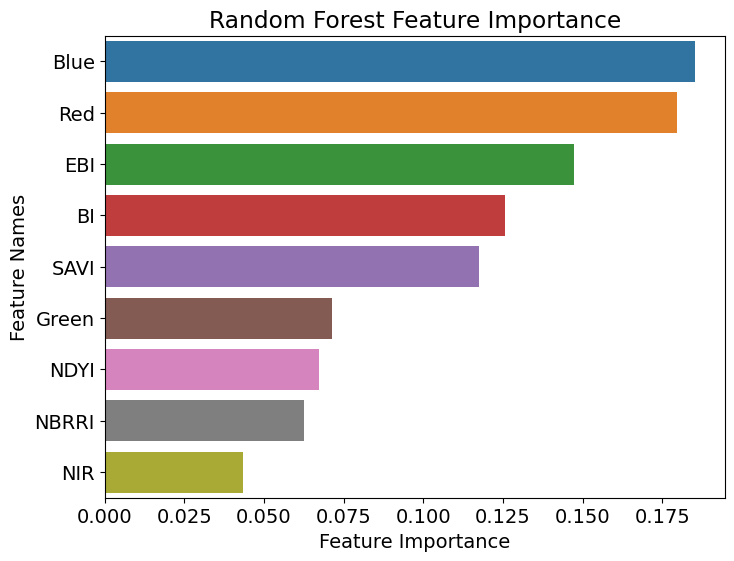

In [27]:
import seaborn as sns
plt.figure(figsize=(3,2))
plot_feature_importance(clf.feature_importances_,X.columns,'Random Forest ', modelName)
# sns = None
# matplotlib.rc_file_defaults()

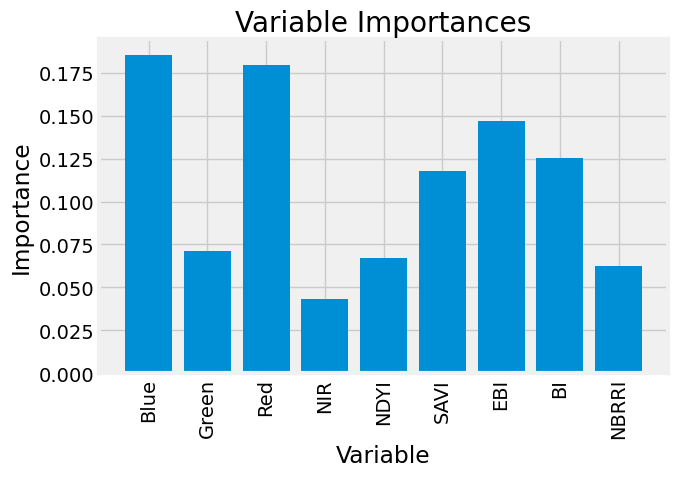

In [275]:
# importance = clf.feature_importances_
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

%matplotlib inline
# Set the style
# fig, ax = plt.subplots(figsize=(6, 4))
plt.figure(figsize=(7,5))
plt.style.use('fivethirtyeight')

# list of index locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.tight_layout()

## RF Hyperparameter Tuning

In [28]:
# For old execution random_state = 0

rf_base = RandomForestClassifier(random_state=10, n_jobs=-1)
# rf_base = XGBClassifier(random_state=0, n_jobs=-1)

n_estimators = [int(x) for x in np.arange(20, 65, 5)]
# n_estimators = [int(x) for x in np.arange(10, 65, 10)] % Previous Execution
# np.linspace(start = 20, stop = 100, num = 50)
max_depth = [int(x) for x in np.linspace(2, 3, num = 2)]
max_features = ['log2', 'sqrt']
min_samples_split = [3, 5, 8, 10]
bootstrap = [True, False]
criterion=['gini', 'entropy', 'log_loss']

# random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features':max_features, \
#                'criterion': criterion}

random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features':max_features, \
               'min_samples_split':min_samples_split, 'bootstrap': bootstrap, 'criterion': criterion}

print(random_grid)

{'n_estimators': [20, 25, 30, 35, 40, 45, 50, 55, 60], 'max_depth': [2, 3], 'max_features': ['log2', 'sqrt'], 'min_samples_split': [3, 5, 8, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy', 'log_loss']}


In [29]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

scoring = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid,
                               n_iter=300, cv = cv, error_score='raise', random_state=10,
                               scoring = scoring, verbose=1, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 15 folds for each of 300 candidates, totalling 4500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
                   error_score='raise',
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=10),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 3],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_split': [3, 5, 8, 10],
                                        'n_estimators': [20, 25, 30, 35, 40, 45,
                                                         50, 55, 60]},
                   random_state=10,
                   scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
                   verbose=1)

In [30]:
print(rf_random.best_params_)
y_pred = rf_random.predict(X_test)
y_proba = rf_random.predict_proba(X_test)
modelName = input("Input model name for saving results")

{'n_estimators': 55, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}


Input model name for saving results Model_RF_HPT_newTrained


In [31]:
bestmodel = rf_random.best_estimator_
rf_new = RandomForestClassifier(n_estimators=bestmodel.n_estimators, 
                                max_depth=bestmodel.max_depth, 
                                criterion= bestmodel.criterion, 
                                max_features= bestmodel.max_features, random_state=10, n_jobs=-1)
rf_new.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=55, n_jobs=-1, random_state=10)

In [32]:
feature_list = list(X_train.columns)
print('Feature List', feature_list)
importances = list(rf_new.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature List ['Blue', 'Green', 'Red', 'NIR', 'NDYI', 'SAVI', 'EBI', 'BI', 'NBRRI']
Variable: Blue                 Importance: 0.18
Variable: Red                  Importance: 0.18
Variable: EBI                  Importance: 0.16
Variable: SAVI                 Importance: 0.13
Variable: BI                   Importance: 0.12
Variable: Green                Importance: 0.07
Variable: NDYI                 Importance: 0.07
Variable: NBRRI                Importance: 0.06
Variable: NIR                  Importance: 0.04


<Figure size 400x300 with 0 Axes>

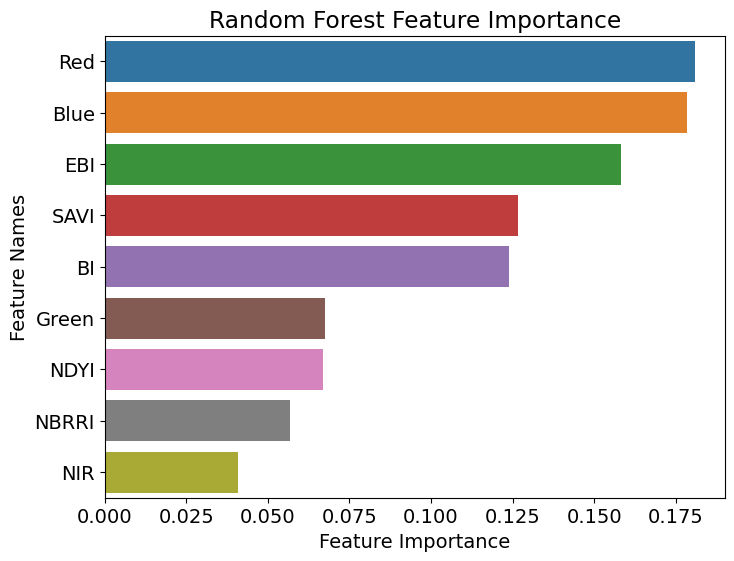

In [33]:
import seaborn as sns
plt.figure(figsize=(4,3))
plot_feature_importance(rf_new.feature_importances_,X.columns,'Random Forest ', modelName)
# sns = None
# matplotlib.rc_file_defaults()

Classification Accuracy of the model: 77.78%
Jaccard Score of the model:  [0.6579 0.6    0.6486]
ROC AUC (OvR) Score of the model:  [0.9233 0.9022 0.9539]
Confusion Matrix

Classification Report
              precision    recall  f1-score   support

 Heterotheca      0.758     0.833     0.794        30
    Outgroup      0.808     0.700     0.750        30
        Soil      0.774     0.800     0.787        30

    accuracy                          0.778        90
   macro avg      0.780     0.778     0.777        90
weighted avg      0.780     0.778     0.777        90



<Figure size 300x300 with 0 Axes>

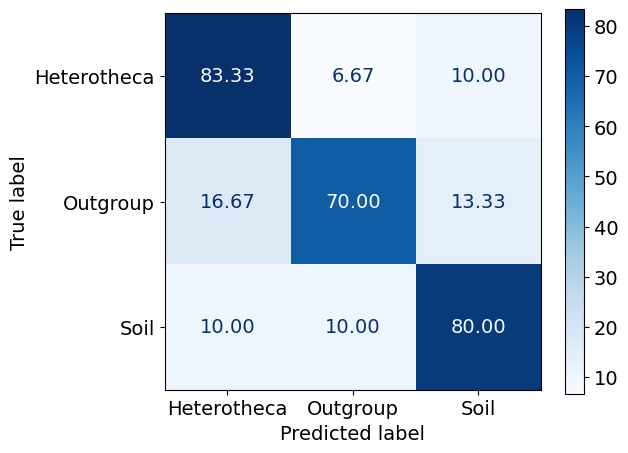

In [34]:
# Classification Results
matplotlib.rc_file_defaults()
classificationDetails(rf_random, X_train, y_train, X_test, y_test, y_pred, y_proba, datasetType + '_' + modelName)

In [35]:
# Pickle Save
dumpName = './Outputs/Models/' + datasetType + '_' + modelName + '.pkl'
pickle.dump(rf_random, open(dumpName, 'wb'))

# Load trained model
# rf_random = pickle.load(open(dumpName, 'rb'))
# y_pred = rf_random.predict(X_test)

Image bands 8
Image crs:  EPSG:32636


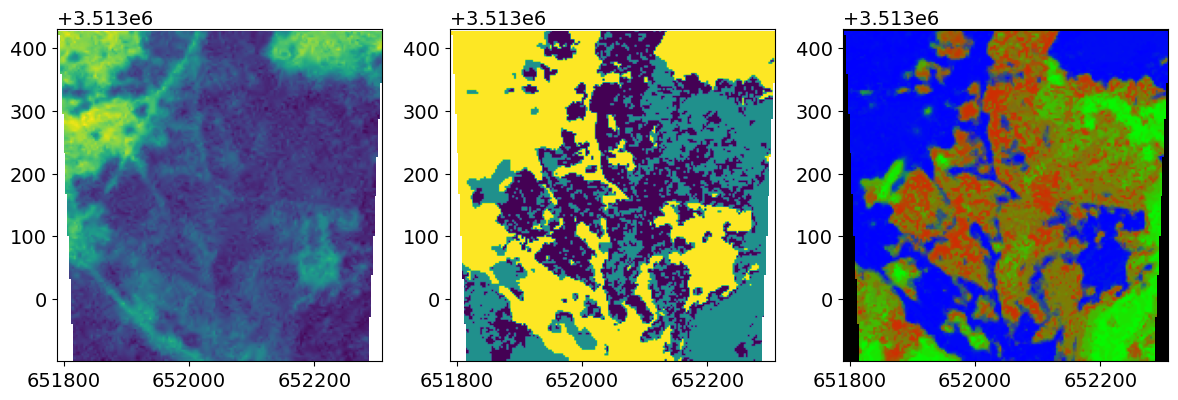

0 ROC AUC OvR: 0.9233
1 ROC AUC OvR: 0.9022
2 ROC AUC OvR: 0.9539
average ROC AUC OvR: 0.9265


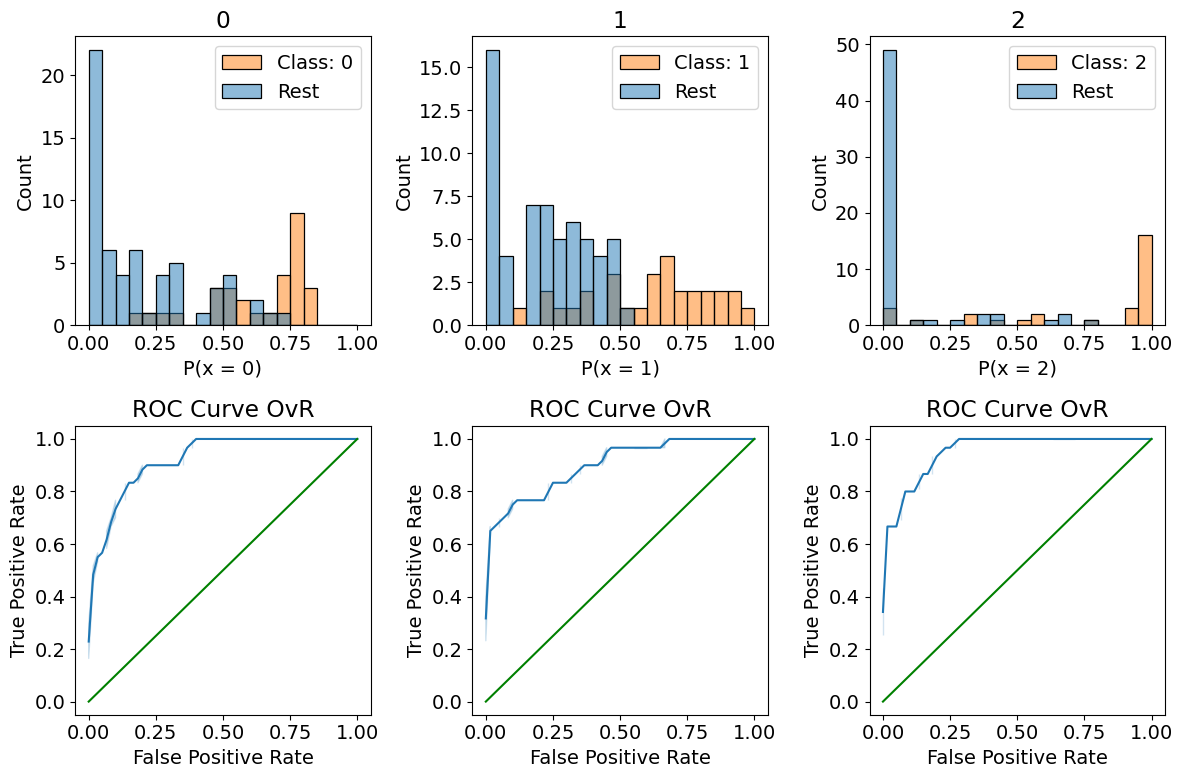

In [36]:
# Apply basic model on full image
# matplotlib.rc_file_defaults()
import seaborn as sns
applyFullImage(imageName, datasetType, rf_random, modelName)
OvR_ROC(rf_random, X_test, y_test, y_proba, datasetType, modelName)

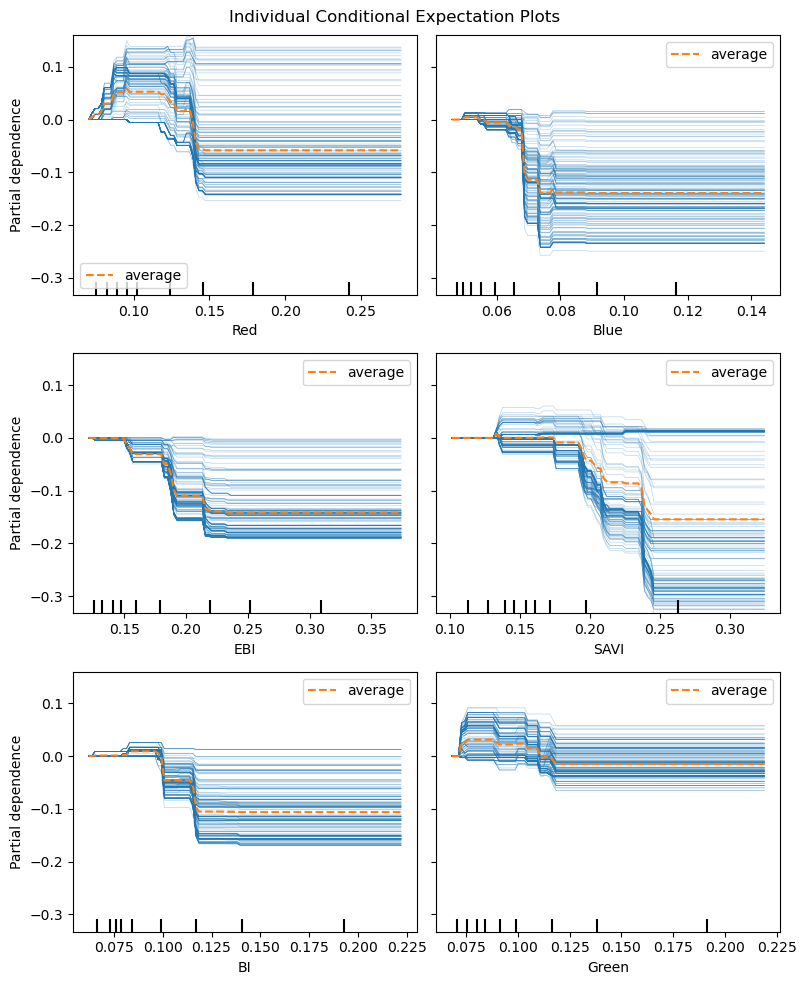

In [21]:
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay)
modelName = 'Model_RF_HPT'
# Load trained model
rf_random = pickle.load(open('./Outputs/Models/9Bands_Model_RF_HPT_newTrained.pkl', 'rb'))

var = ['Red', 'Blue', 'EBI', 'SAVI', 'BI', 'Green']#, 'Saturation', 'NDYI', 'MGRVI']

n_cols = 2
n_rows = int(len(var)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(8, 10))
PartialDependenceDisplay.from_estimator(rf_random, X_train, var, target=0,\
                                        ax=ax, n_cols=n_cols, kind='both', centered=True, n_jobs=-1)
# PartialDependenceDisplay.from_estimator(rf_random, X_train, var, target=0, line_kw={"color": "red"},\
#                                         ax=ax, n_cols=n_cols, centered=True, n_jobs=-1)
# fig.suptitle('Partial Dependence Plots')
fig.suptitle('Individual Conditional Expectation Plots')
fig.tight_layout()

# plt.savefig('./Outputs/PDP_'+modelName+'.png', dpi=300, bbox_inches='tight')
plt.savefig('./Outputs/ICE_'+modelName+'.png', dpi=300, bbox_inches='tight')

## Apply on Planet 1km x 1km grids of images
- Parallel Processing

In [42]:
# Function for applying classification results on all images

def applyFullImageFolder(address):
    model = rf_random
    modelName = 'Model_RF_HPT_newTrained'
    datasetType = '9Bands'
    output_dir = os.path.dirname('./Planet_Images/')
    # Image loading and size checking
    head, tail = os.path.split(address)
    fname, fext = os.path.splitext(tail)
    img_val = rio.open(address)
    # print('Image bands', img_val.count)
    # print('Image crs: ', img_val.crs)
    rows = img_val.height
    cols = img_val.width
    # print('Cols', cols)
    # print('Rows', rows)
    noBandsVal = img_val.count
    im1 = img_val.read(1)
    
    # Converting image to dataframe
    img_r = []
    for i in range(1, noBandsVal+1):
        temp = img_val.read(i)
        img_r.append(temp/10000)

    img_r = np.stack(img_r, axis=0)
    img_df = pd.DataFrame(img_r.reshape([noBands,-1]).T, \
                          columns=['B1','Blue','G1','Green','Yellow','Red','RedEdge','NIR'])
    img_df = img_df[['Blue','Green','Red','NIR']]

    img_df = img_df.replace(-1, np.nan)
    img_df = img_df.replace(0, np.nan)
    
    if datasetType == '4Bands':
        img_df = img_df
    else:
        img_df = computeIndices(img_df)
    
    img_df = img_df.replace(np.nan, -1)
    
    # Predict probability (3 bands generated)
    # band 0 - Heterotheca
    # band 1 - Outgroup
    # band 2 - Soil
    y_pred_prob = model.predict_proba(img_df)
    
    def apply_mask_border(img, gt):
        img = np.where(gt == 0, np.nan, img)
        return img
        
    y_pred_prob_reshape = np.zeros((3, rows, cols))
    y_pred_prob_reshape[0, :, :] = y_pred_prob[:,0].reshape(rows, cols)
    y_pred_prob_reshape[1, :, :] = y_pred_prob[:,1].reshape(rows, cols)
    y_pred_prob_reshape[2, :, :] = y_pred_prob[:,2].reshape(rows, cols)
    
    for i in range(0, 3):
        y_pred_prob_reshape[i, :, :] = apply_mask_border(y_pred_prob_reshape[i, :, :], im1)
    
    # Predict classes
    # y_pred_val = model.predict(img_df) # Default classification threshold is 0.5
    # y_pred_val = y_pred_val.astype('float32')    
        
    # y_pred_val_reshape = np.reshape(y_pred_val, (1, rows, cols))
    # y_pred_val_reshape = apply_mask_border(y_pred_val_reshape, im1)
    
    # meta = img_val.meta.copy()
    # meta.update({'count':1})
    # meta.update({'dtype':'float32'})
    # meta.update({'nodata':-1})
    metaprob = img_val.meta.copy()
    metaprob.update({'count':3})
    metaprob.update({'dtype':'float32'})
    metaprob.update({'nodata':-1})
    
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9), tight_layout=True)
    # show(img_val, ax=ax1, extent=tiff_extent , transform=img.transform)
    # show(y_pred_val_reshape, ax=ax2, extent=tiff_extent , transform=img.transform)
    # show(y_pred_prob_reshape, ax=ax3, extent=tiff_extent , transform=img.transform)
    # plt.show()
    
    output_file = fname + '_' + datasetType + '_' + modelName + '_Prob.tif'
    outprobfilename = os.path.join(output_dir, output_file)
    with rio.open(outprobfilename, 'w', **metaprob) as outprob:
        outprob.write(y_pred_prob_reshape)
    return None

In [43]:
from multiprocessing import Pool
import os
import time

input_dir = os.path.dirname('./Planet_Images/')
pathFolder = sorted(glob.glob(input_dir + r'/*.tif'))

def main():
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(applyFullImageFolder, pathFolder)
        p.close()
if __name__ == '__main__':
    main()

## Zipping Results

In [1]:
import os
import zipfile    

def zipit(folders, zip_filename):
    zip_file = zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED)

    for folder in folders:
        for dirpath, dirnames, filenames in os.walk(folder):
            for filename in filenames:
                zip_file.write(
                    os.path.join(dirpath, filename),
                    os.path.relpath(os.path.join(dirpath, filename), os.path.join(folders[0], '../..')))

    zip_file.close()

folders = ["Ashdod_Image", "Input_Images", "Outputs"]

zipit(folders, "PlanetScope_Image_Results.zip")